# How to model ebs using `chromo`

Here I'll show quickly how to use `chromo` to model an EB.

In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
from chromo import eb
import lightkurve as lk

In [3]:
import matplotlib.pyplot as plt

Below we're using the same steps from a previous demo to analyze the EB Zeta Phe

In [4]:
# Grab an object
tic = 'Zet Phe'
sr = lk.search_tesscut(tic)
# Download an FFI cut out!
raw_tpf = sr[0].download(cutout_size=[30, 30])

# Cut out any jitter
k = ~((raw_tpf.time > 1346) & (raw_tpf.time < 1350))
raw_tpf = raw_tpf[k]

# No nan frames
raw_tpf = raw_tpf[(raw_tpf.to_lightcurve().flux > 0)]

tpf = eb.background_correct(raw_tpf)

17 cadences will be ignored (bitmask=175)
0 cadences will be ignored (bitmask=175)
0 cadences will be ignored (bitmask=175)
0 cadences will be ignored (bitmask=175)


In [6]:
# See other notebooks for how to find period and t0 estimates
period, tref = 1.6695564535964362, 0.7686931840715678

0 cadences will be ignored (bitmask=175)
Calculating Pixel Light Curves: 100%|██████████| 30/30 [00:02<00:00, 11.07it/s]


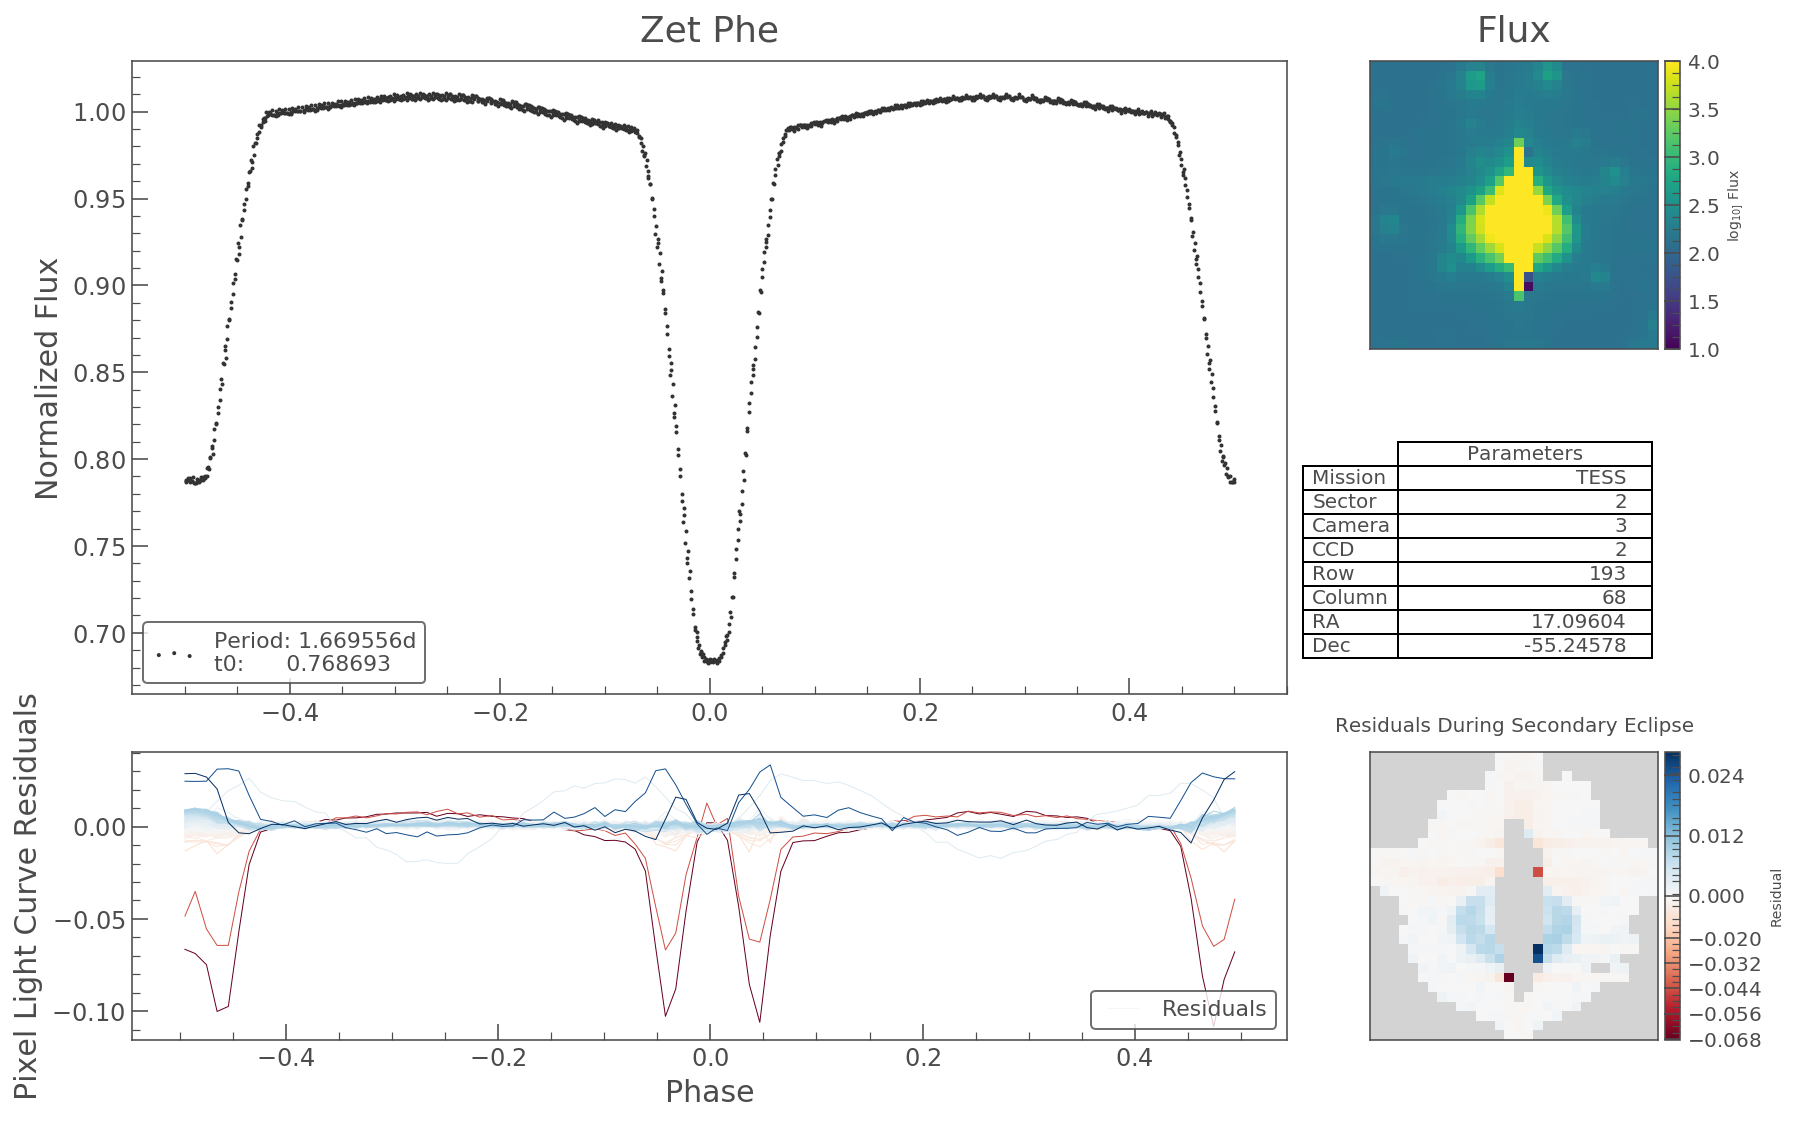

In [7]:
# Use Chromo to analyze! This will make movies in your current directory!
result = eb.analyze(raw_tpf, period, tref, name='{}'.format(tic), nb=100, score_threshold=-300, saturation_aggression=5);

# Modeling the 'white light' curve

The first step is to model the 'white light' (full aperture) light curve. Below I've set up some initial guesses for the Zeta Phe parameters.

In [8]:
lc = tpf.to_lightcurve()

In [9]:
init = {'radius': 0.6491228070175439,
         'L': 0.20569620253164558,
         'ellipsoidal amplitude': -0.01,
         'reflection_amplitude': -0.005,
         'primary_u_0': 0.1044,
         'primary_u_1': 0.2248,
         'secondary_u_0': 0.1253,
         'secondary_u_1': 0.2357,
         'tref': 0.7686931840715678,
         'period': 1.6695564535964362,
         'inclination': 84,
         'omega': 13,
         'eccentricity': 0.0113,
         'a': 3.5}

Now we can build a model using these parameters

In [10]:
model = eb.modeling.Model(init)

In [11]:
model

+-----------------------+----------------+-------------------+--------------+
|                       |   Inital Guess | Bounds            |   Best Guess |
|-----------------------+----------------+-------------------+--------------|
| radius                |       0.649123 | (0.3000, 0.9000)  |          nan |
| L                     |       0.205696 | (0.0500, 0.5000)  |          nan |
| ellipsoidal amplitude |      -0.01     | (-0.1000, 0.0000) |          nan |
| reflection_amplitude  |      -0.005    | (-0.1000, 0.0000) |          nan |
| primary_u_0           |       0.1044   | (0, 1)            |          nan |
| primary_u_1           |       0.2248   | (0, 1)            |          nan |
| secondary_u_0         |       0.1253   | (0, 1)            |          nan |
| secondary_u_1         |       0.2357   | (0, 1)            |          nan |
| tref                  |       0.768693 | (0.7587, 0.7787)  |          nan |
| period                |       1.66956  | (1.6496, 1.6896)  |  

The model contains all our initial guesses, some reasonable bounds, and no "best guess" since we've not fit anything yet. We can run the fitting on our light curve easily:

In [12]:
model.fit(lc)

In [13]:
model

+-----------------------+----------------+-------------------+--------------+
|                       |   Inital Guess | Bounds            |   Best Guess |
|-----------------------+----------------+-------------------+--------------|
| radius                |       0.649123 | (0.3000, 0.9000)  |   0.604746   |
| L                     |       0.205696 | (0.0500, 0.5000)  |   0.264165   |
| ellipsoidal amplitude |      -0.01     | (-0.1000, 0.0000) |  -0.00841816 |
| reflection_amplitude  |      -0.005    | (-0.1000, 0.0000) |  -0.00508863 |
| primary_u_0           |       0.1044   | (0, 1)            |   0.1044     |
| primary_u_1           |       0.2248   | (0, 1)            |   0.2248     |
| secondary_u_0         |       0.1253   | (0, 1)            |   0.1253     |
| secondary_u_1         |       0.2357   | (0, 1)            |   0.2357     |
| tref                  |       0.768693 | (0.7587, 0.7787)  |   0.76877    |
| period                |       1.66956  | (1.6496, 1.6896)  |  

Now the model is populated with best guesses! Let's plot it.

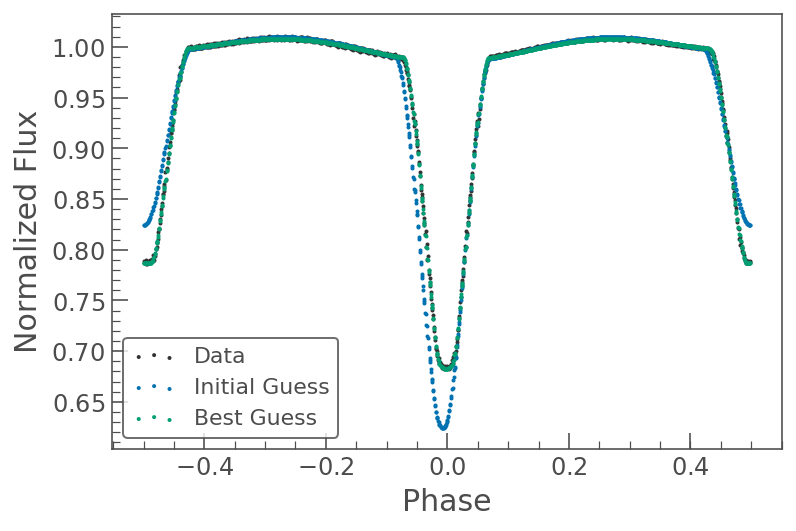

In [14]:
model.plot(lc)

Looks great! Now we want to fit this model to some pixel data. Let's use the `results` object from the `analyze` function to get a pixel light curve:

In [15]:
pixel_lc = lk.LightCurve(lc.time, result['data'][:, 12, 12], result['errors'][:, 12, 12])

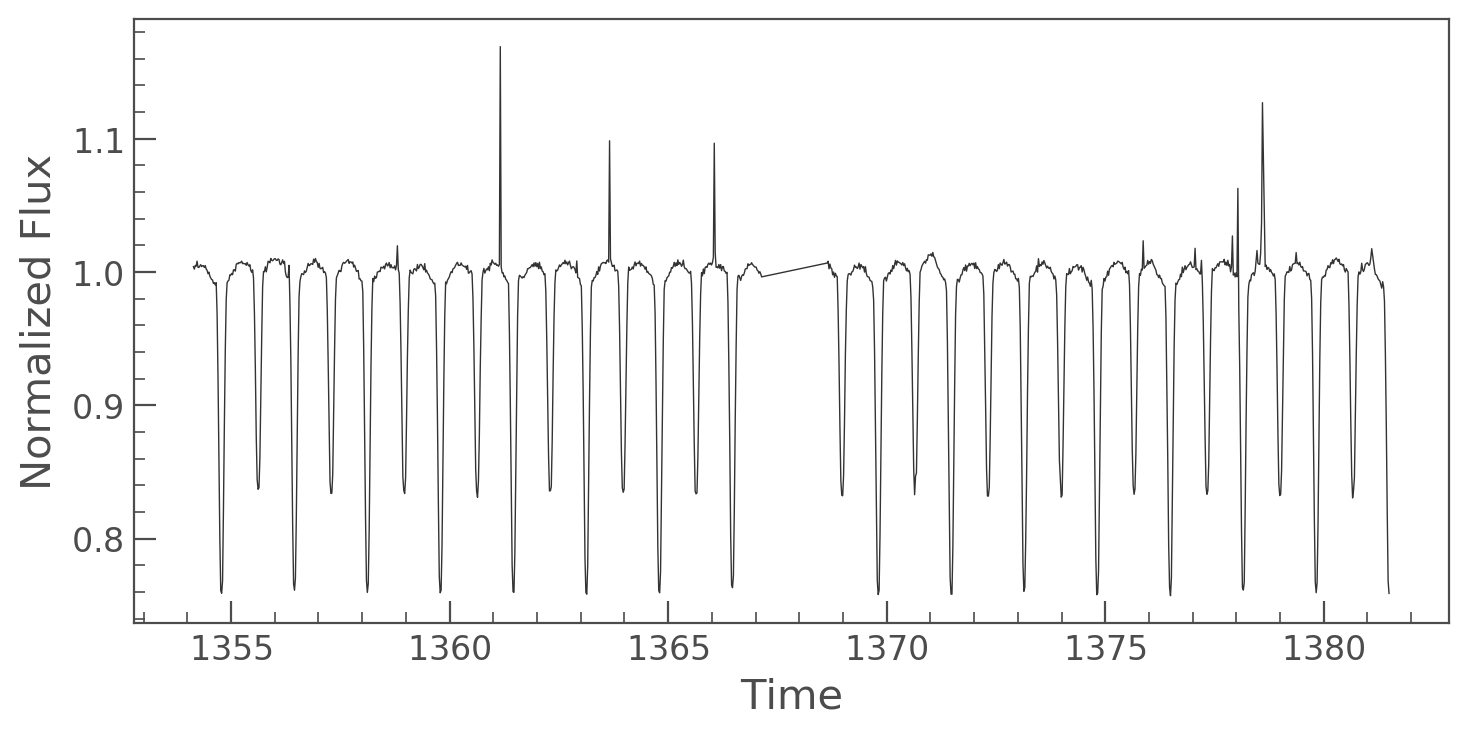

In [16]:
pixel_lc.plot()

Great. Now just pass that into the model fit, and set `fix_orbital` to True. This will fix all our orbital parameters and only fit for `R` and `L`. This is going to use all the parameters that we fit using our 'white light curve'.

In [18]:
model.fit(pixel_lc, fix_orbital=True)

In [20]:
model

+-----------------------+----------------+-------------------+--------------+
|                       |   Inital Guess | Bounds            |   Best Guess |
|-----------------------+----------------+-------------------+--------------|
| radius                |       0.649123 | (0.3000, 0.9000)  |   0.560517   |
| L                     |       0.205696 | (0.0500, 0.5000)  |   0.226555   |
| ellipsoidal amplitude |      -0.01     | (-0.1000, 0.0000) |  -0.00757927 |
| reflection_amplitude  |      -0.005    | (-0.1000, 0.0000) |  -0.00383786 |
| primary_u_0           |       0.1044   | (0, 1)            |   0.1044     |
| primary_u_1           |       0.2248   | (0, 1)            |   0.2248     |
| secondary_u_0         |       0.1253   | (0, 1)            |   0.1253     |
| secondary_u_1         |       0.2357   | (0, 1)            |   0.2357     |
| tref                  |       0.768693 | (0.7587, 0.7787)  |   0.768415   |
| period                |       1.66956  | (1.6496, 1.6896)  |  

Now we can plot that pixel light curve with those model parameters. Looks great!

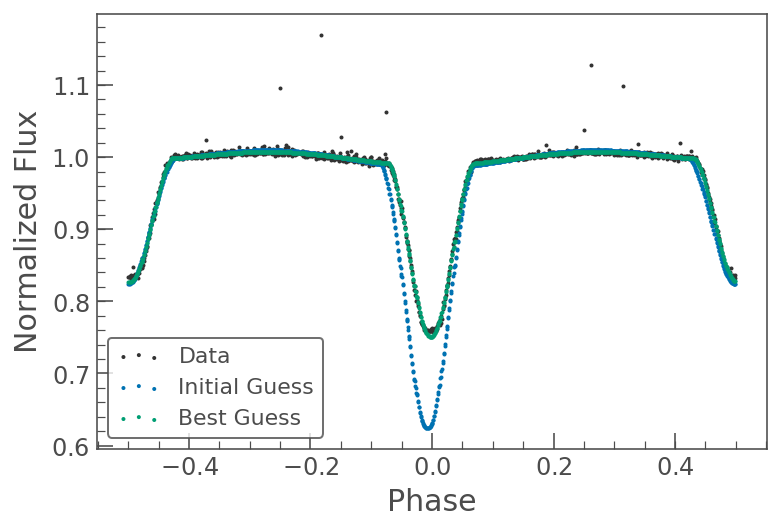

In [22]:
model.plot(pixel_lc)